In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

In [ ]:
def load_and_preprocess_mnist():
    mnist = fetch_openml("mnist_784", version=1)
    data = mnist.data / 255.0
    labels = mnist.target.astype(int)

    images = data.values.reshape(-1, 28, 28)

    return data, labels, images


data, labels, images = load_and_preprocess_mnist()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, encoding_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [23]:
def train_autoencoder(
    model,
    data,
    batch_size=256,
    epochs=100,
    validation_split=0.2,
    patience=10,
    model_path="models/best_model.pt",
):
    from torch.utils.data import DataLoader, TensorDataset, random_split

    # Convert data to PyTorch tensors
    data_tensor = torch.tensor(data.values, dtype=torch.float32)

    # Create train/val split
    val_size = int(len(data_tensor) * validation_split)
    train_size = len(data_tensor) - val_size
    train_data, val_data = random_split(data_tensor, [train_size, val_size])

    # Dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    best_val_loss = float("inf")
    epochs_no_improve = 0

    loss_tab = []
    val_loss_tab = []

    print("Training model...")
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.size(0)

        train_loss /= len(train_loader.dataset)
        loss_tab.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch)
                loss = criterion(output, batch)
                val_loss += loss.item() * batch.size(0)

        val_loss /= len(val_loader.dataset)
        val_loss_tab.append(val_loss)

        print(
            f"Epoch {epoch + 1}/{epochs} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

        # Checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print(f"✅ Validation loss improved. Model saved to {model_path}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⚠️ No improvement for {epochs_no_improve} epoch(s).")

        # Early stopping
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered.")
            break

    print("Training complete.")
    return loss_tab, val_loss_tab

In [49]:
encoding_dim = 2
model = AutoEncoder(encoding_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6

In [50]:
loss, val_loss = train_autoencoder(
    model=model,
    data=data,
    batch_size=256,
    epochs=100,
    validation_split=0.2,
    patience=10,
    model_path="models/best_autoencoder_2d.pt",
)

Training model...
Epoch 1/100 — Train Loss: 0.0839, Val Loss: 0.0635
✅ Validation loss improved. Model saved to models/best_autoencoder_2d.pt
Epoch 2/100 — Train Loss: 0.0581, Val Loss: 0.0523
✅ Validation loss improved. Model saved to models/best_autoencoder_2d.pt
Epoch 3/100 — Train Loss: 0.0526, Val Loss: 0.0503
✅ Validation loss improved. Model saved to models/best_autoencoder_2d.pt
Epoch 4/100 — Train Loss: 0.0499, Val Loss: 0.0458
✅ Validation loss improved. Model saved to models/best_autoencoder_2d.pt
Epoch 5/100 — Train Loss: 0.0463, Val Loss: 0.0451
✅ Validation loss improved. Model saved to models/best_autoencoder_2d.pt
Epoch 6/100 — Train Loss: 0.0450, Val Loss: 0.0426
✅ Validation loss improved. Model saved to models/best_autoencoder_2d.pt
Epoch 7/100 — Train Loss: 0.0441, Val Loss: 0.0429
⚠️ No improvement for 1 epoch(s).
Epoch 8/100 — Train Loss: 0.0434, Val Loss: 0.0413
✅ Validation loss improved. Model saved to models/best_autoencoder_2d.pt
Epoch 9/100 — Train Loss: 0.0

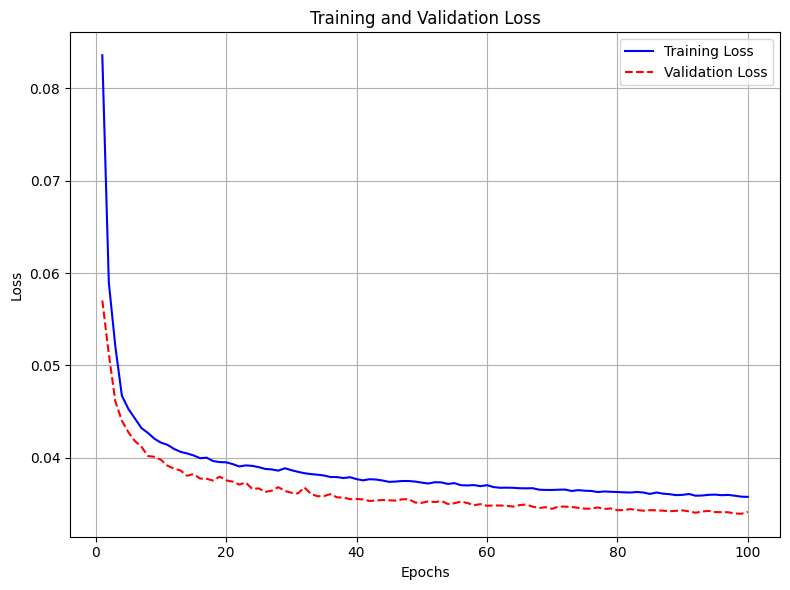

In [ ]:
def plot_loss(loss, val_loss):
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, "b-", label="Training Loss")
    plt.plot(epochs, val_loss, "r--", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss(loss, val_loss)

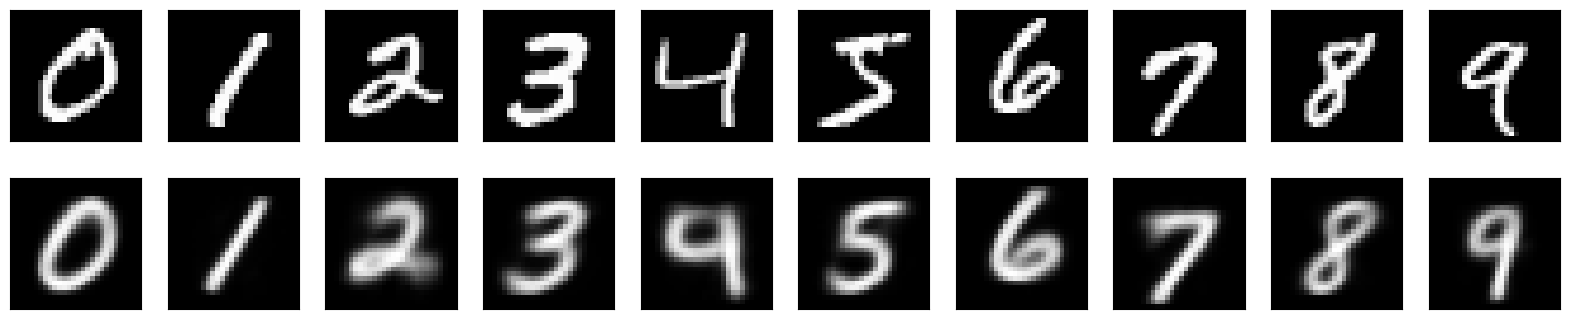

In [27]:
model = AutoEncoder(encoding_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load("models/best_autoencoder_2d.pt", map_location=device))
model.eval()

with torch.no_grad():
    input_tensor = torch.tensor(data.values, dtype=torch.float32)
    input_tensor = input_tensor.to(device)
    reconstructed = model(input_tensor)

unique_labels = np.unique(labels)
n = len(unique_labels)
selected_indices = [np.where(labels == label)[0][0] for label in unique_labels]

plt.figure(figsize=(20, 4))
for i, idx in enumerate(selected_indices):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Visualisation de l'espace latent


In [28]:
import random

seed = 42
np.random.seed(seed)
random.seed(seed)


def plot_latent_space_with_labels(encoded_data, labels):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        encoded_data[:, 0],
        encoded_data[:, 1],
        c=labels,
        cmap="tab10",
        alpha=0.7,
        edgecolors="w",
        linewidth=0.5,
    )
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend1)
    plt.xlabel("Latent Variable 1")
    plt.ylabel("Latent Variable 2")
    plt.title("Latent Space Representation Colored by Class Labels")
    plt.show()


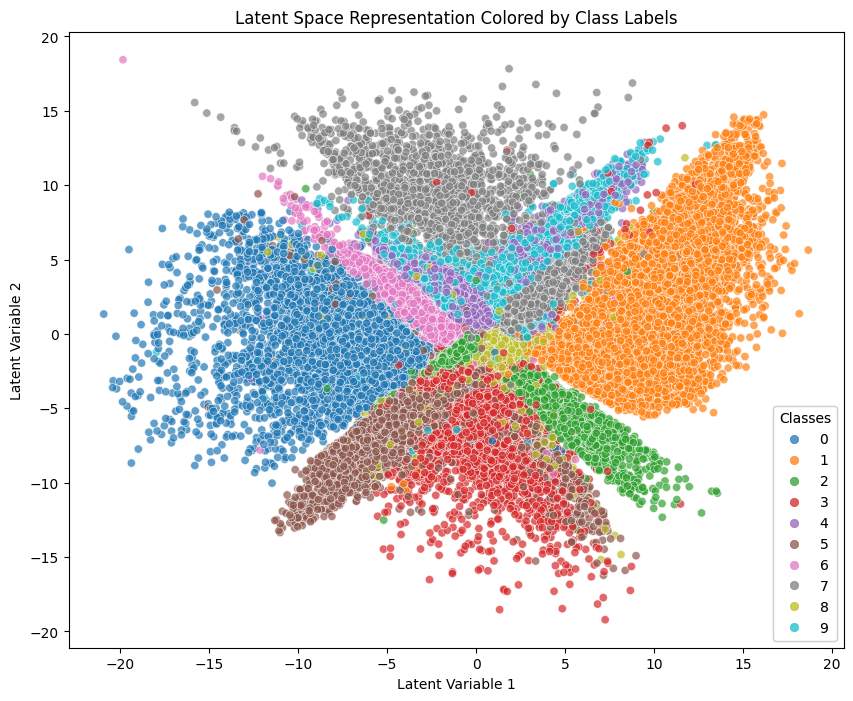

In [ ]:
model = AutoEncoder(encoding_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load("best_autoencoder.pt", map_location=device))
model.eval()

encoder = model.encoder
encoder.eval()

with torch.no_grad():
    input_tensor = torch.tensor(data.values, dtype=torch.float32).to(device)
    encoded_data = encoder(input_tensor)

indices = np.arange(encoded_data.shape[0])
np.random.shuffle(indices)
encoded_data = encoded_data[indices]
labels = labels[indices]

plot_latent_space_with_labels(encoded_data, labels)

# Visualisation en 3D


In [29]:
encoding_dim = 3
model = AutoEncoder(encoding_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Linear(in_features=128, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6

In [ ]:
loss, val_loss = train_autoencoder(
    model=model,
    data=data,
    batch_size=256,
    epochs=100,
    validation_split=0.2,
    patience=10,
    model_path="models/best_autoencoder_3d.pt",
)

Training model...
Epoch 1/100 — Train Loss: 0.0825, Val Loss: 0.0438
✅ Validation loss improved. Model saved to best_autoencoder_3d.pt
Epoch 2/100 — Train Loss: 0.0429, Val Loss: 0.0393
✅ Validation loss improved. Model saved to best_autoencoder_3d.pt
Epoch 3/100 — Train Loss: 0.0420, Val Loss: 0.0383
✅ Validation loss improved. Model saved to best_autoencoder_3d.pt
Epoch 4/100 — Train Loss: 0.0384, Val Loss: 0.0350
✅ Validation loss improved. Model saved to best_autoencoder_3d.pt
Epoch 5/100 — Train Loss: 0.0368, Val Loss: 0.0340
✅ Validation loss improved. Model saved to best_autoencoder_3d.pt
Epoch 6/100 — Train Loss: 0.0360, Val Loss: 0.0332
✅ Validation loss improved. Model saved to best_autoencoder_3d.pt
Epoch 7/100 — Train Loss: 0.0355, Val Loss: 0.0331
✅ Validation loss improved. Model saved to best_autoencoder_3d.pt
Epoch 8/100 — Train Loss: 0.0350, Val Loss: 0.0325
✅ Validation loss improved. Model saved to best_autoencoder_3d.pt
Epoch 9/100 — Train Loss: 0.0345, Val Loss: 0.

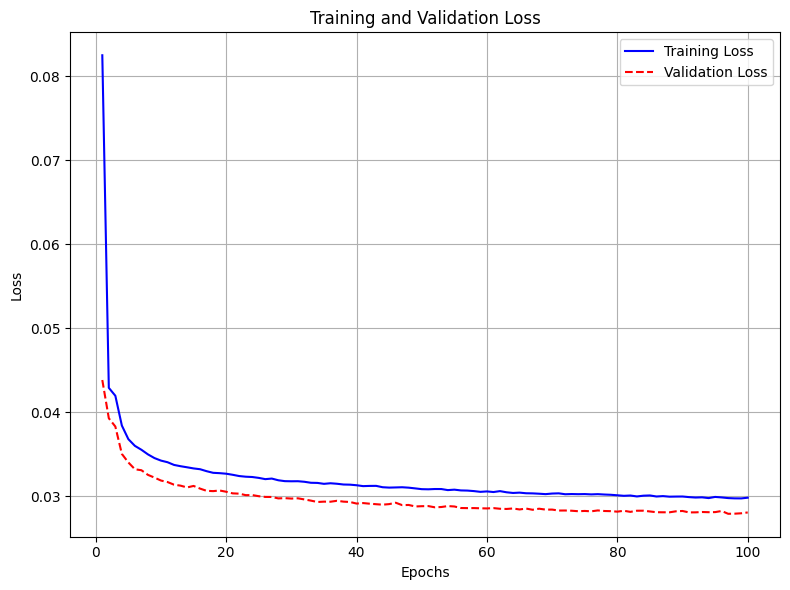

In [31]:
plot_loss(loss, val_loss)

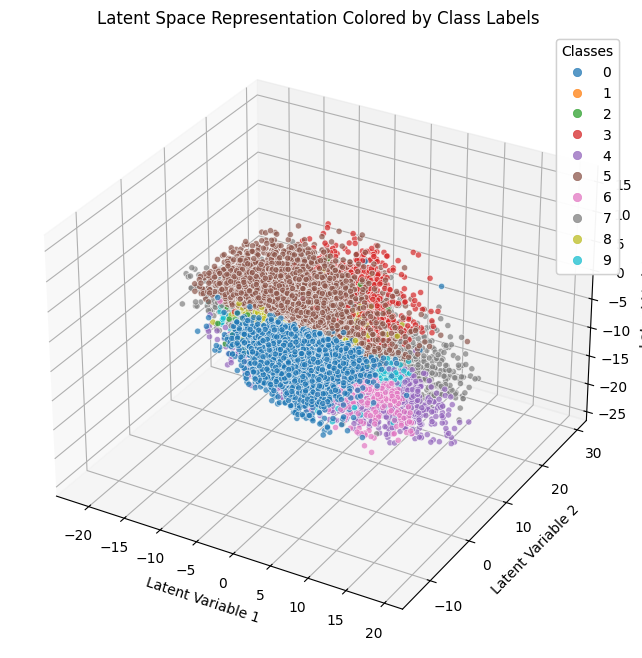

In [34]:
model = AutoEncoder(encoding_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load("models/best_autoencoder_3d.pt", map_location=device))
model.eval()

encoder = model.encoder
encoder.eval()

with torch.no_grad():
    input_tensor = torch.tensor(data.values, dtype=torch.float32).to(device)
    encoded_data = encoder(input_tensor)

indices = np.arange(encoded_data.shape[0])
np.random.shuffle(indices)
encoded_data = encoded_data[indices]
labels = labels[indices]


def plot_latent_space_with_labels_3d(encoded_data, labels):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(
        encoded_data[:, 0],
        encoded_data[:, 1],
        encoded_data[:, 2],
        c=labels,
        cmap="tab10",
        alpha=0.7,
        edgecolors="w",
        linewidth=0.5,
    )
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)
    ax.set_xlabel("Latent Variable 1")
    ax.set_ylabel("Latent Variable 2")
    ax.set_zlabel("Latent Variable 3")
    ax.set_title("Latent Space Representation Colored by Class Labels")
    plt.show()


plot_latent_space_with_labels_3d(encoded_data, labels)

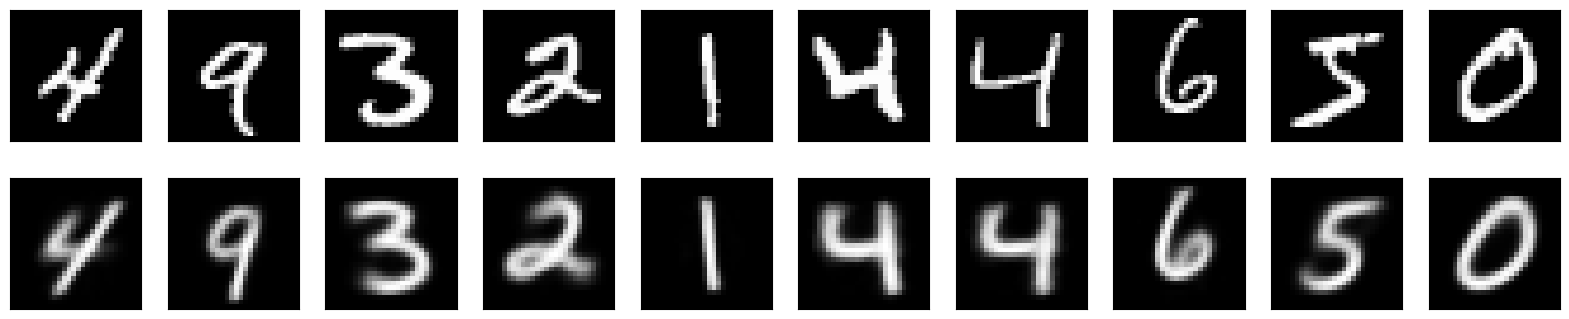

In [38]:
model = AutoEncoder(encoding_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load("models/best_autoencoder_3d.pt", map_location=device))
model.eval()

with torch.no_grad():
    input_tensor = torch.tensor(data.values, dtype=torch.float32)
    input_tensor = input_tensor.to(device)
    reconstructed = model(input_tensor)

unique_labels = np.unique(labels)
n = len(unique_labels)
selected_indices = [np.where(labels == label)[0][0] for label in unique_labels]

plt.figure(figsize=(20, 4))
for i, idx in enumerate(selected_indices):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


# Génération d'images


## 2D


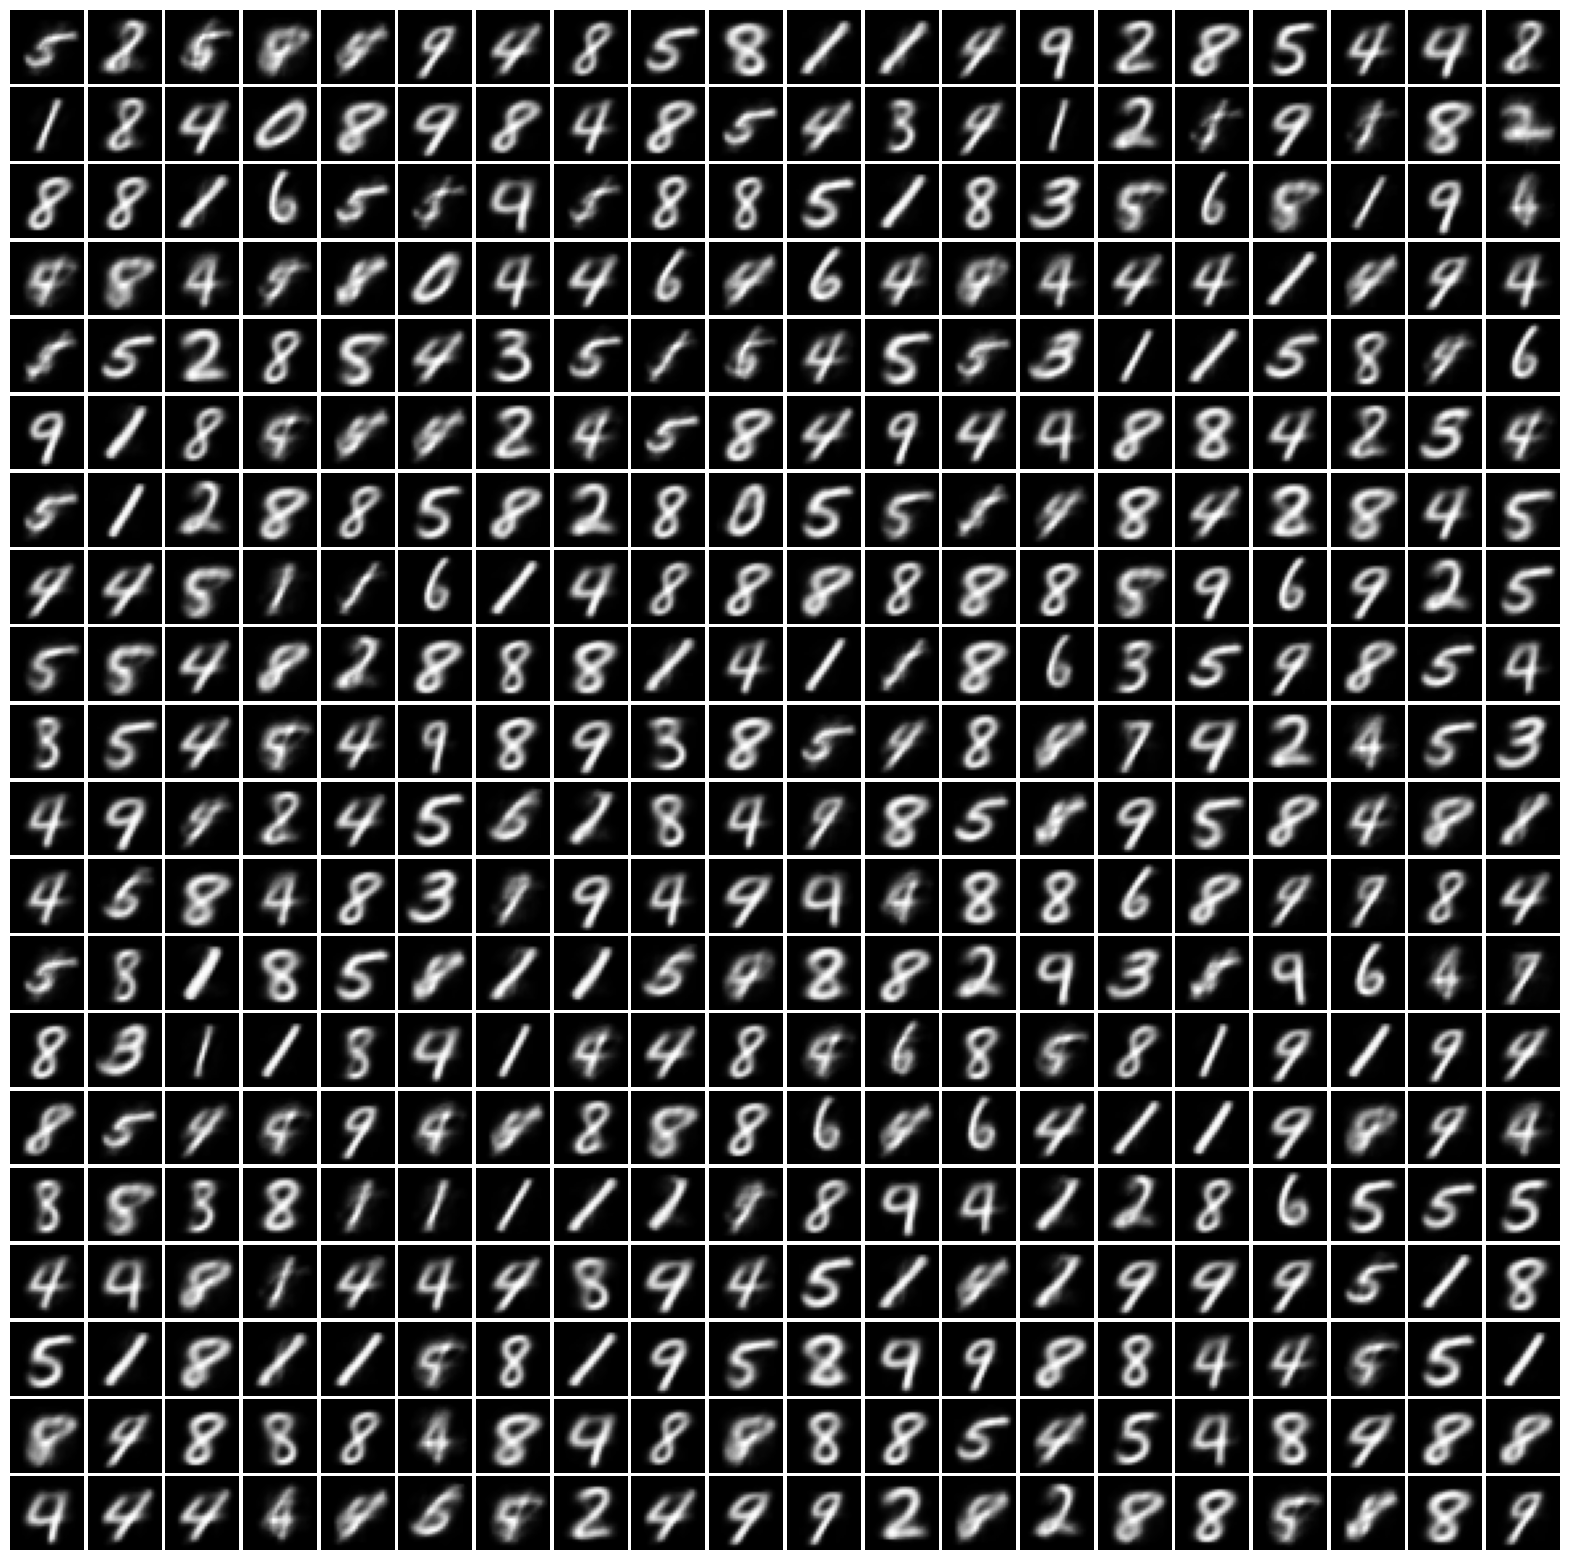

In [ ]:
model = AutoEncoder(encoding_dim=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load("models/best_autoencoder_2d.pt", map_location=device))
model.eval()


def generate_and_plot_images(
    decoder, encoding_dim, num_images=400, image_size=(28, 28), device="cpu"
):
    decoder.eval()

    # Generate random latent vectors
    z = torch.randn(num_images, encoding_dim).to(device)

    # Decode to images
    with torch.no_grad():
        generated_images = decoder(z).cpu().view(-1, *image_size)

    # Plot images in 20x20 grid
    fig, axes = plt.subplots(20, 20, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap="gray")
        ax.axis("off")

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


generate_and_plot_images(
    model.decoder, encoding_dim=2, num_images=400, image_size=(28, 28), device=device
)


# Generation D'image

## 3D


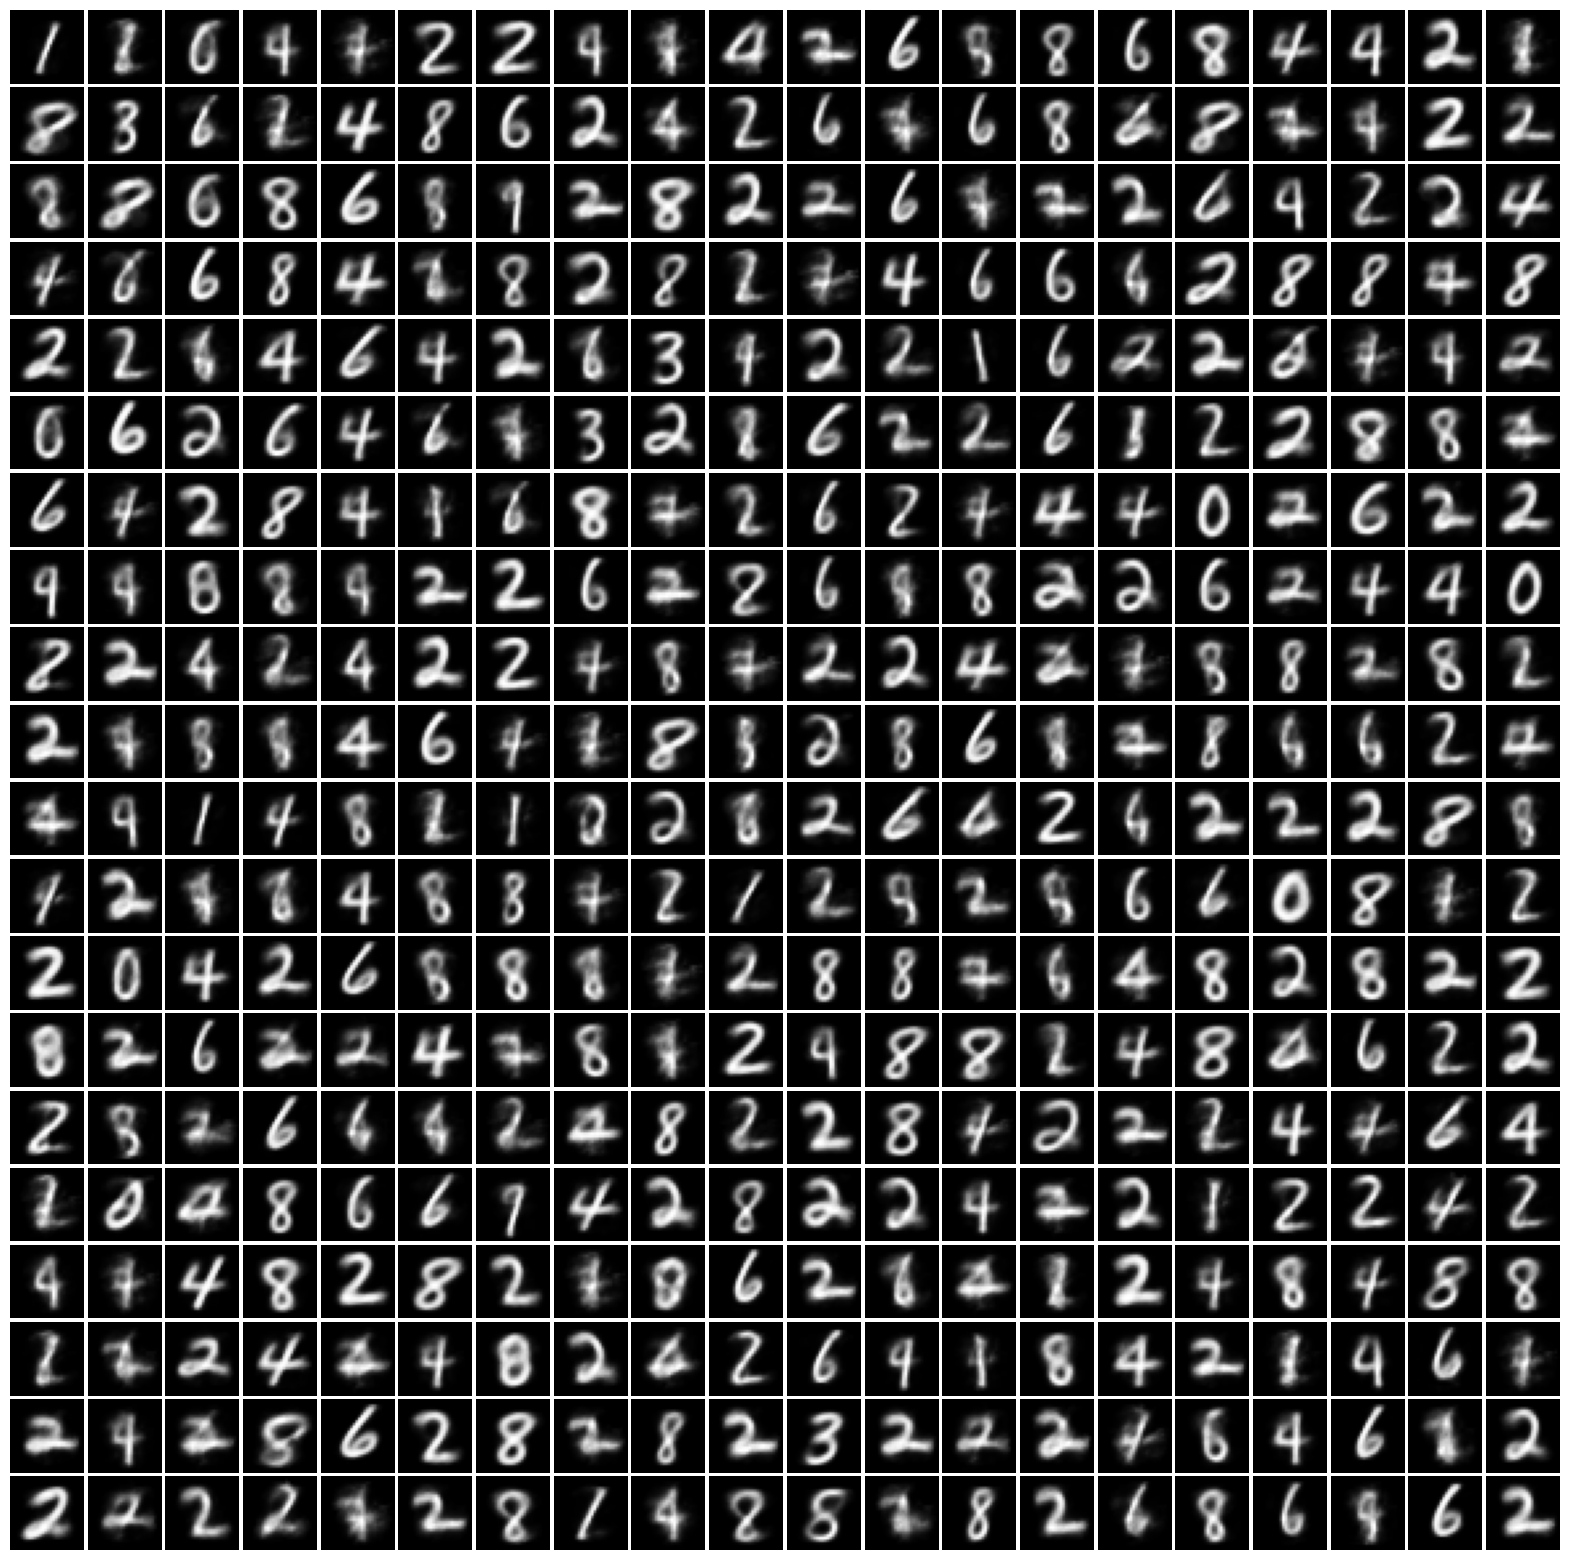

In [47]:
model = AutoEncoder(encoding_dim=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load("models/best_autoencoder_3d.pt", map_location=device))
model.eval()

generate_and_plot_images(
    model.decoder, encoding_dim=3, num_images=400, image_size=(28, 28), device=device
)
